# Analyze neutralization data
This Python Jupyter notebook analyzes the neutralization data.

Import Python modules.
We use [neutcurve](https://jbloomlab.github.io/neutcurve/) to plot the neutralization curves:

In [1]:
import os
import re
import warnings

from IPython.display import display, HTML
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *
from statistics import geometric_mean

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import yaml

print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 0.5.7


Read config file

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Specify input / output files:

In [3]:
# output directory
results='results/neut_titers'
os.makedirs(results, exist_ok = True)

# input files
fracinfect_file = 'results/neut_titers/fracinfect.csv'

# output files
neut_titers_file = f'{results}/neut_titers.csv'
all_replicate_curves = f'{results}/all_replicate_curves.pdf'

Read in the neutralization data, dropping sera/viruses that were messed up and repeated:

In [4]:
print(config['rename_sera'])

{'23_d21': 'participant A (day 21)', '24C_d32': 'participant C (day 32)', '23C_d26': 'participant I (day 26)', '1C_d26': 'participant B (day 26)'}


In [5]:
print(f"Reading neutralization data from {fracinfect_file}")
fracinfect = (pd.read_csv(fracinfect_file)
              .replace({'B.1.351':'wildtype', 'mock':'wildtype', 'D614G':'wildtype'})
              .replace(config['rename_sera'])
             )

# order the viruses
virus_order = config['virus_order']
serum_order = config['serum_order']

print(f"Length before dropping anything = {len(fracinfect.index)}")
    
if config['neut_samples_ignore']:    
    for dat in config['neut_samples_ignore']:
        viruses = config['neut_samples_ignore'][dat]
        print(f'From {dat}, dropping {viruses}')
        l = len((fracinfect[(fracinfect['virus'].isin(viruses)) & (fracinfect['date'].astype(str) == str(dat))]))
        print(fracinfect[(fracinfect['virus'].isin(viruses)) & (fracinfect['date'].astype(str) == str(dat))]['virus'].unique())
        fracinfect = fracinfect.drop(fracinfect[((fracinfect['virus'].isin(viruses)) & (fracinfect['date'].astype(str) == str(dat)))].index)
        print(f"Length after dropping {l} rows from {viruses} from {dat} = {len(fracinfect.index)}")

fracinfect = (
    fracinfect
    .assign(replicate_with_date=lambda x: x['replicate'].astype(str) +
                                          ' (' + x['date'] + ')')
    .query('virus in @virus_order & serum in @serum_order')
    .assign(virus=lambda x: pd.Categorical(x['virus'], virus_order, ordered=True))
    .rename(columns={'replicate': 'replicate_on_date'})
)
fracinfect = (
    fracinfect
    .merge(fracinfect
           .sort_values('date')
           [['serum', 'virus', 'replicate_with_date']]
           .drop_duplicates()
           .assign(replicate_all_dates=lambda x: x.groupby(['serum', 'virus'])
                                                  ['replicate_with_date']
                                                  .transform('cumcount') + 1
                   ),
            how='left', on=['serum', 'virus', 'replicate_with_date'], validate='many_to_one',
            )
    )

# show first few lines of data frame
display(HTML(fracinfect.head().to_html(index=False)))

Reading neutralization data from results/neut_titers/fracinfect.csv
Length before dropping anything = 2240
From 2021-08-20, dropping ['B.1.351-K484Q']
['B.1.351-K484Q']
Length after dropping 64 rows from ['B.1.351-K484Q'] from 2021-08-20 = 2176
From 2021-08-21, dropping ['B.1.351-K484Q']
['B.1.351-K484Q']
Length after dropping 64 rows from ['B.1.351-K484Q'] from 2021-08-21 = 2112


serum,virus,replicate_on_date,concentration,fraction infectivity,date,replicate_with_date,replicate_all_dates
K041,B.1.351-K484Q,1,0.040000,4.610000e-07,2021-08-27,1 (2021-08-27),2
K041,B.1.351-K484Q,1,0.013330,2.739000e-03,2021-08-27,1 (2021-08-27),2
K041,B.1.351-K484Q,1,0.004444,2.070000e-02,2021-08-27,1 (2021-08-27),2
K041,B.1.351-K484Q,1,0.001481,2.479000e-01,2021-08-27,1 (2021-08-27),2
K041,B.1.351-K484Q,1,0.000494,9.689000e-01,2021-08-27,1 (2021-08-27),2


In [6]:
fits = neutcurve.curvefits.CurveFits(
            data=fracinfect,
            replicate_col='replicate_all_dates',
            fixbottom=config['fixbottom'],
            fixtop=config['fixtop'],
    
            )

Saving plot to results/neut_titers/all_replicate_curves.pdf



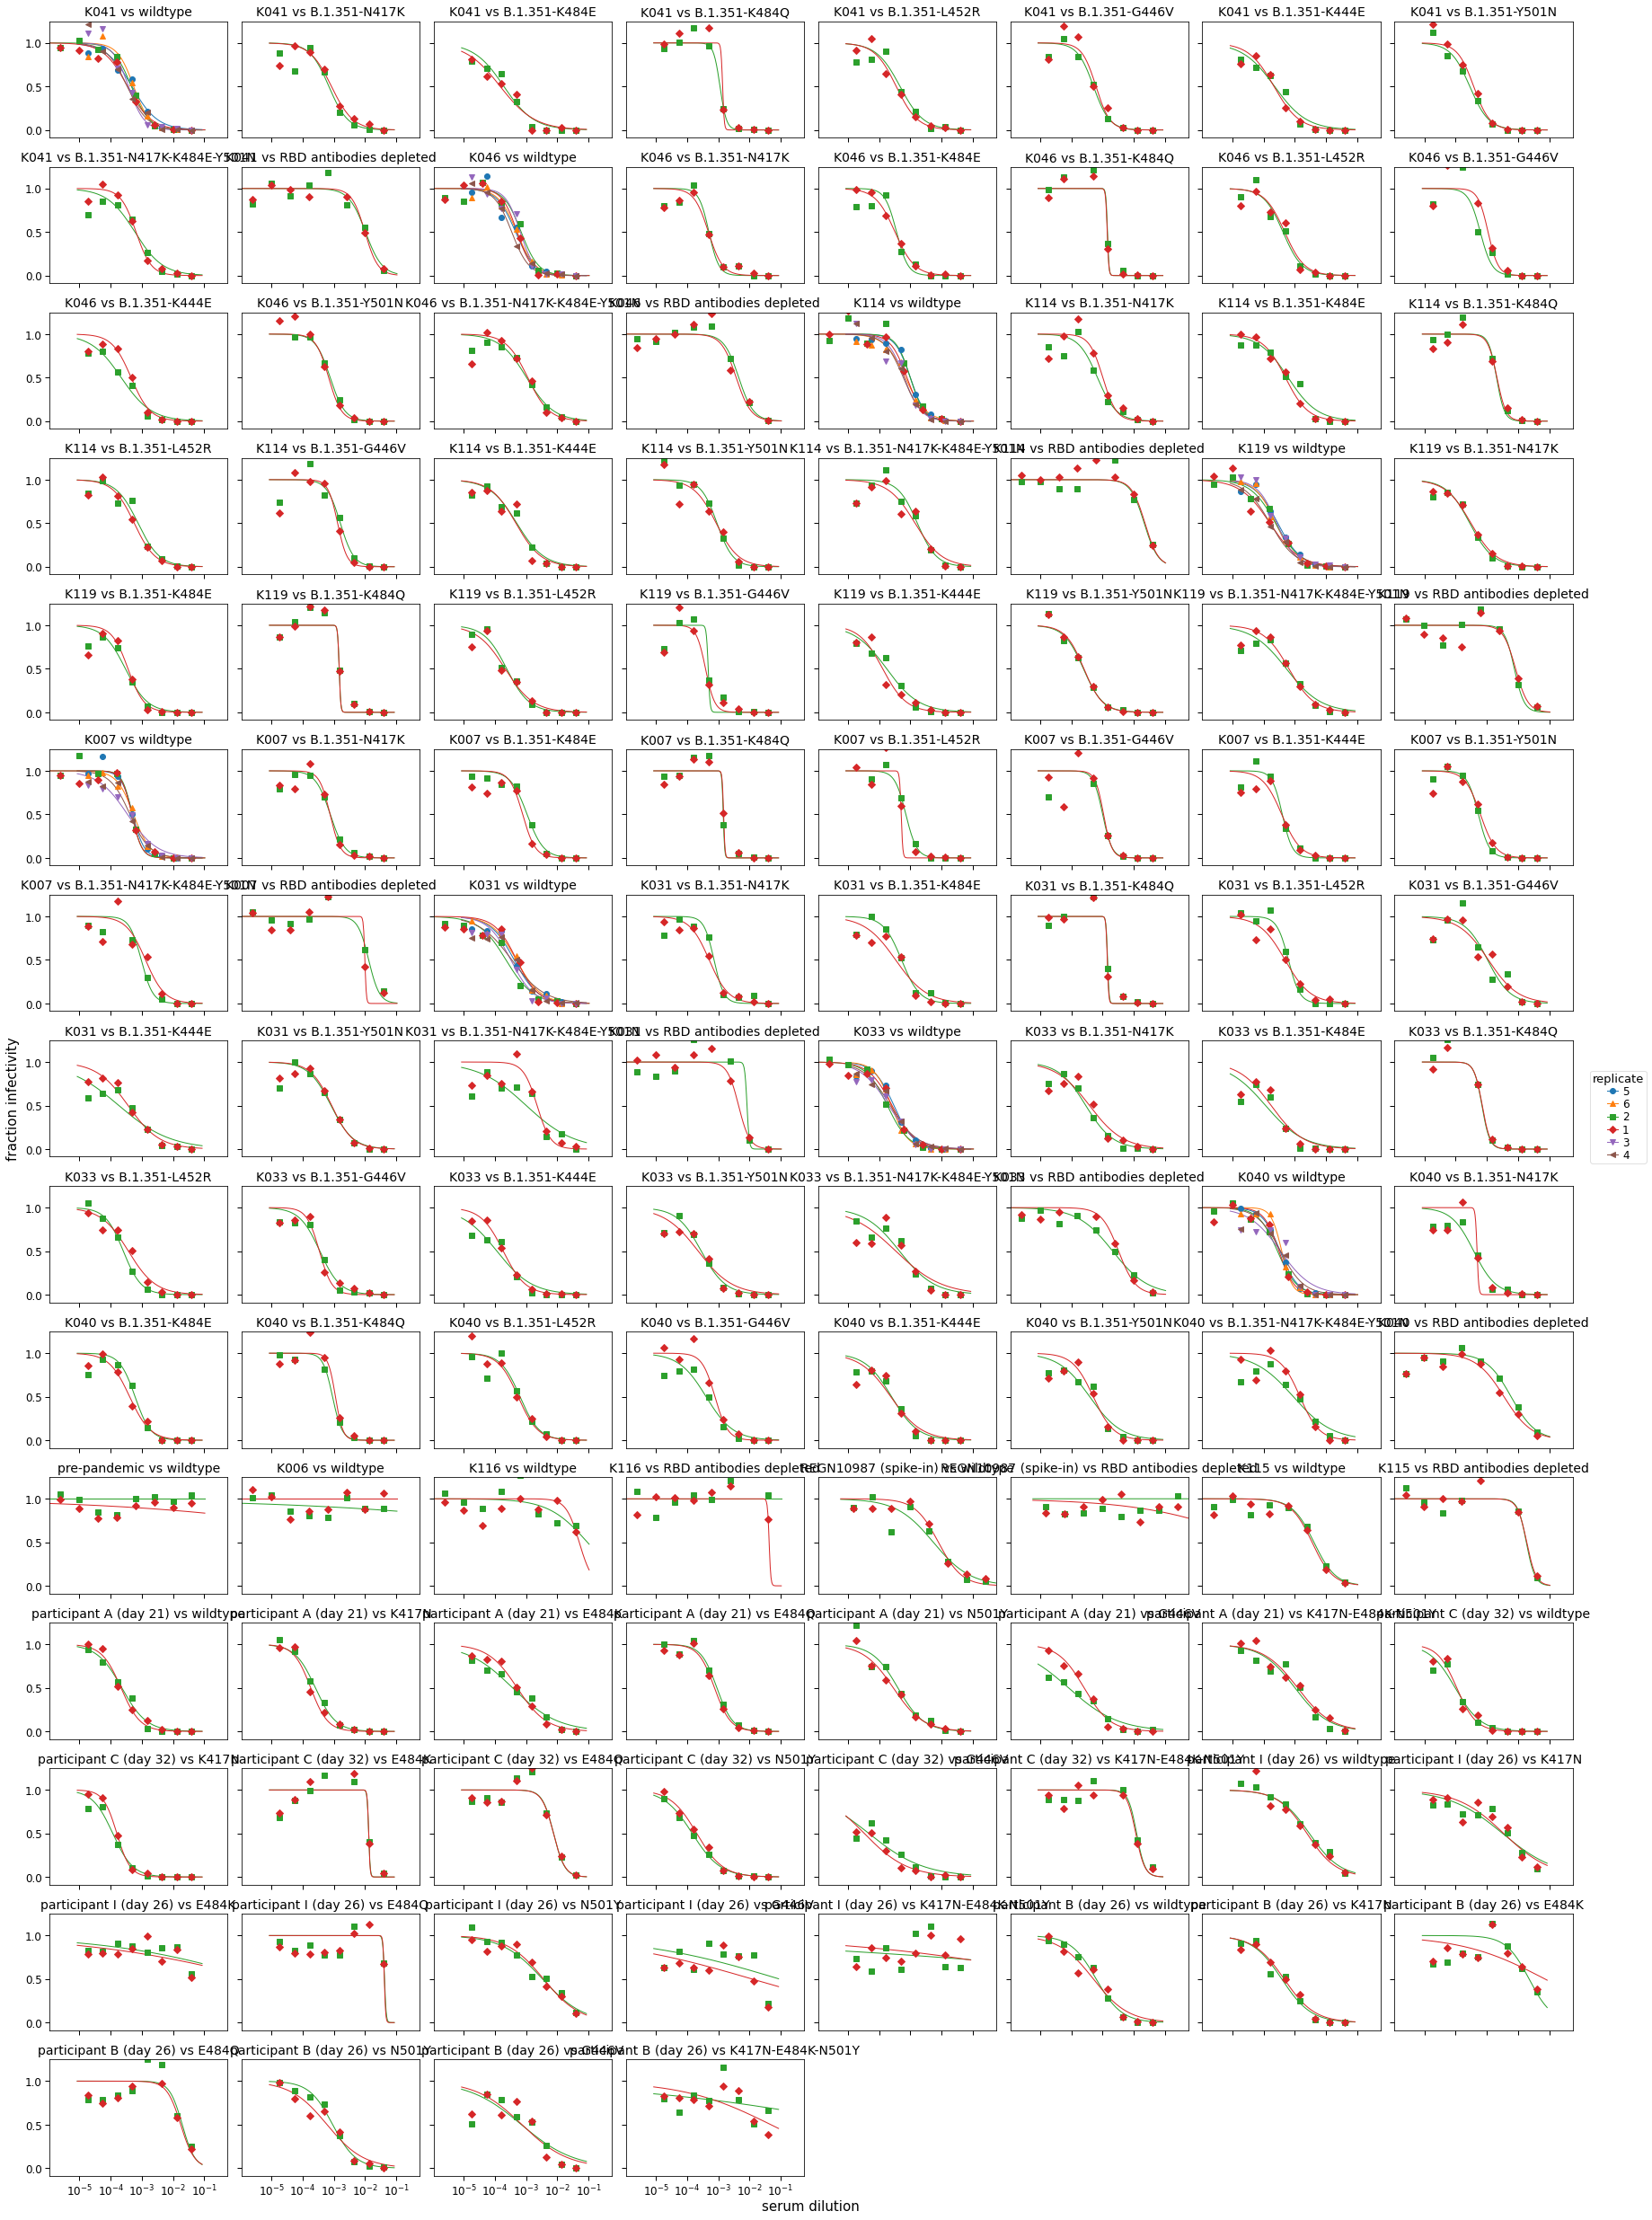

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # ignore fitting warnings
    fig, _ = fits.plotReplicates(ncol=8,
                                 legendtitle='replicate',
                                 xlabel='serum dilution',
                                 viruses=fracinfect['virus'].sort_values().unique(),
                                 colors=plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2,
                                 markers=['o', '^', 's', 'D', 'v', '<', '>', 'p'] * 2,
                                 fix_lims={'ymax':1.25},
                                 )
    
print(f"Saving plot to {all_replicate_curves}\n")
fig.savefig(all_replicate_curves)
fig.tight_layout()
display(fig)
plt.close(fig)

Use [neutcurve](https://jbloomlab.github.io/neutcurve/) to fit neutralization curves to all of the data:

In [8]:
fitparams = pd.DataFrame(columns=['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date'])

for d in fracinfect['date'].unique():
    fits = neutcurve.CurveFits(fracinfect.query('date==@d'),
                               replicate_col='replicate_on_date',
                               fixbottom=config['fixbottom'],
                               fixtop=config['fixtop'],
                              )

    fp = (
        fits.fitParams(average_only=False)
        .assign(NT50=lambda x: 1/x['ic50'],
                date=d
               )
        .replace({'WT':'wildtype', 'B.1.351':'wildtype'})
        # get columns of interest
        [['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date', 'replicate', 'top']] 
        .assign(ic50_is_bound=lambda x: x['ic50_bound'].map({'lower': True,
                                                          'interpolated': False}))
        )
    fitparams=fitparams.append(fp, ignore_index=True)

fitparams.head()

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: divide by zero encountered in true_divide


,serum,virus,ic50,NT50,ic50_bound,date,replicate,top,ic50_is_bound
0,K041,B.1.351-K484Q,0.001137,879.582341,interpolated,2021-08-27,1,True,False
1,K041,B.1.351-K484Q,0.001380,724.861603,interpolated,2021-08-27,2,True,False
2,K041,B.1.351-K484Q,0.001393,717.838222,interpolated,2021-08-27,average,True,False
3,K041,wildtype,0.000481,2077.386549,interpolated,2021-08-27,1,True,False
4,K041,wildtype,0.000548,1824.055316,interpolated,2021-08-27,2,True,False


### Compare IC50s and fold-change IC50s when the top of the neutralization curve is fixed vs. not fixed

Here we compare the IC50s and fold-change IC50s with the two different methods of fitting the curves. 
See the config file for how we ultimately decided to fit curves.

In [9]:
fitparams_fixtop = pd.DataFrame(columns=['serum', 'virus', 'ic50_fixtop', 'date'])

if config['fixtop']:
    fixtop_alternative=False
else:
    fixtop_alternative=True

for d in fracinfect['date'].unique():
    fits = neutcurve.CurveFits(fracinfect.query('date==@d'),
                               replicate_col='replicate_on_date',
                               fixtop=fixtop_alternative,
                              )

    fp = (
        fits.fitParams(average_only=False)
        .replace({'WT':'wildtype', 'mock':'wildtype', 'B.1.351':'wildtype'})
        .assign(date=d)
        # get columns of interest
        [['serum', 'virus', 'ic50', 'date', 'replicate']]
        .rename(columns={'ic50':'ic50_fixtop'})
        )
    fitparams_fixtop=fitparams_fixtop.append(fp, ignore_index=True)

fitparams_fixtop = (fitparams_fixtop
                    .merge(fitparams_fixtop
                           .query('virus == "wildtype"')
                           [['serum', 'ic50_fixtop', 'date', 'replicate']]
                           .rename(columns={'ic50_fixtop': 'wildtype_ic50_fixtop'}),
                           on=['serum', 'date', 'replicate'],
                           how='left',
                           validate='many_to_one',
                          )
                    .assign(fold_change=lambda x: x['ic50_fixtop'] / x['wildtype_ic50_fixtop'],
                           )
                    .merge(fitparams
                           [['virus', 'serum', 'ic50', 'date', 'replicate']]
                           .merge(fitparams.query('virus == "wildtype"')
                                  [['serum', 'ic50', 'date', 'replicate']]
                    .rename(columns={'ic50': 'wildtype_ic50'}),
                                  on=['serum', 'date', 'replicate'],
                                  how='left',
                                  validate='many_to_one',
                                 )
                           .assign(fold_change_fixtop=lambda x: x['ic50'] / x['wildtype_ic50'],
                                  ),
                           how='outer',
                           on=['serum', 'virus', 'date', 'replicate']
                          )
                   )


display(HTML(fitparams_fixtop.head().to_html()))

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/neutcurve/hillcurve.py:451: RuntimeWarning: invalid value encountered in sqrt


,serum,virus,ic50_fixtop,date,replicate,wildtype_ic50_fixtop,fold_change,ic50,wildtype_ic50,fold_change_fixtop
0,K041,B.1.351-K484Q,0.001090,2021-08-27,1,0.000544,2.002853,0.001137,0.000481,2.361787
1,K041,B.1.351-K484Q,0.001401,2021-08-27,2,0.000560,2.501544,0.001380,0.000548,2.516419
2,K041,B.1.351-K484Q,0.001168,2021-08-27,average,0.000562,2.078311,0.001393,0.000527,2.643227
3,K041,wildtype,0.000544,2021-08-27,1,0.000544,1.000000,0.000481,0.000481,1.000000
4,K041,wildtype,0.000560,2021-08-27,2,0.000560,1.000000,0.000548,0.000548,1.000000


Plot correlations between IC50 whether top is fixed or not

Saving to results/neut_titers/fixtop_corr_ic50.pdf
Saving to results/neut_titers/fixtop_corr_fold_change.pdf


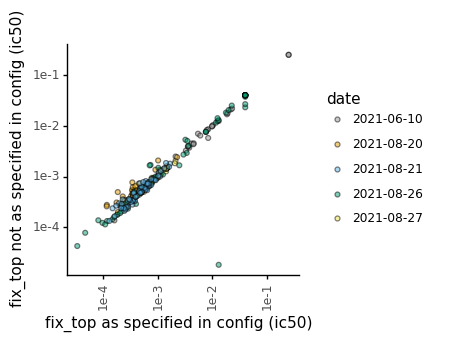

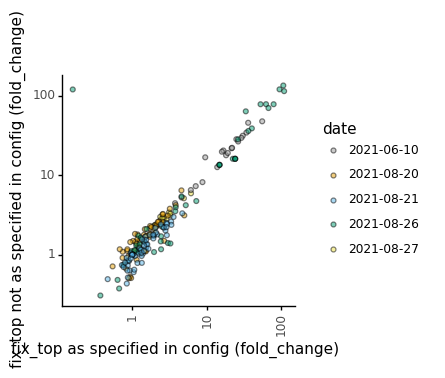

In [10]:
for param in [('ic50', 'ic50_fixtop'), ('fold_change', 'fold_change_fixtop')]:
    p = (ggplot(fitparams_fixtop
                .query("replicate != 'average'")
                ) +
         aes(param[0], param[1],
            ) +
         geom_point(aes(fill='date'), size=1.5, alpha=0.5, ) + #fill='#999999', 
         scale_x_log10(name=f'fix_top as specified in config ({param[0]})') +
         scale_y_log10(name=f'fix_top not as specified in config ({param[0]})') +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(3, 3),
               ) +
         scale_fill_manual(values=CBPALETTE*3)
         )

    _ = p.draw()
    
    plotfile = f'{results}/fixtop_corr_{param[0]}.pdf'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

Make a plot showing all viruses against each sera:

Saving to results/neut_titers/2021-08-27_mutant_neuts.pdf


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power


Saving to results/neut_titers/2021-06-10_mutant_neuts.pdf
Saving to results/neut_titers/2021-08-20_mutant_neuts.pdf


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated


Saving to results/neut_titers/2021-08-26_mutant_neuts.pdf
Saving to results/neut_titers/2021-08-21_mutant_neuts.pdf


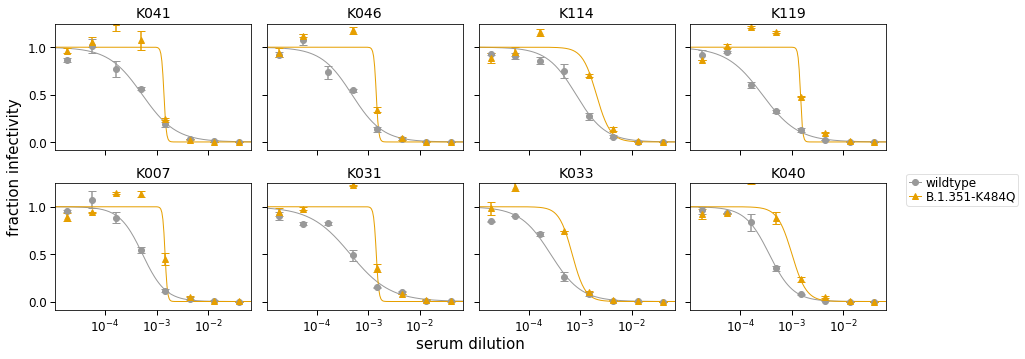

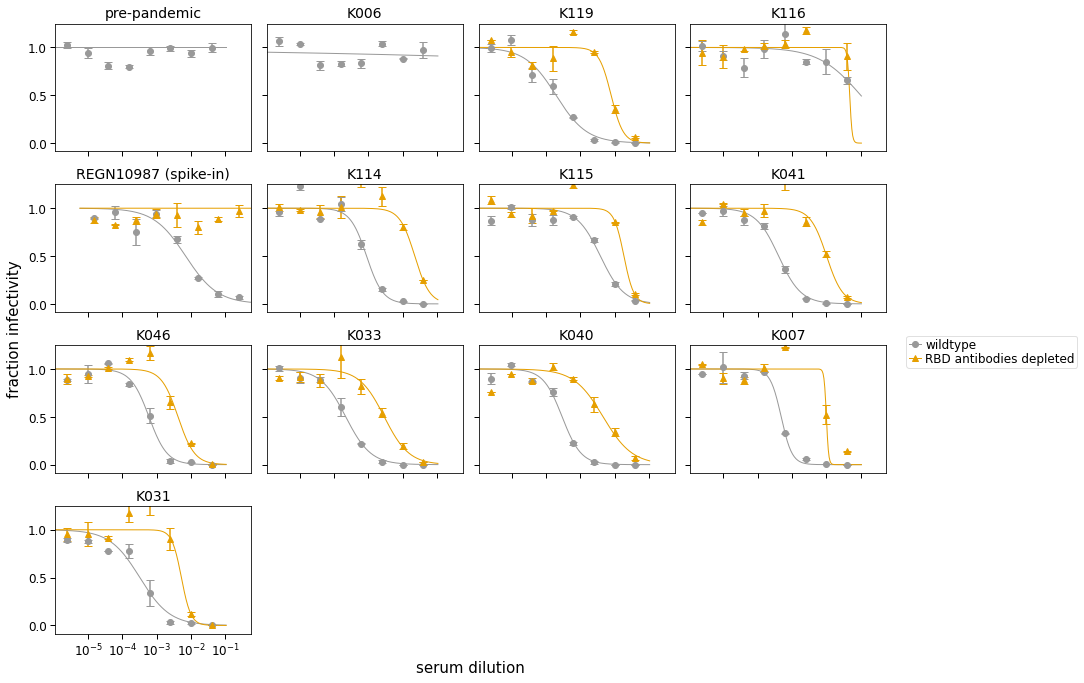

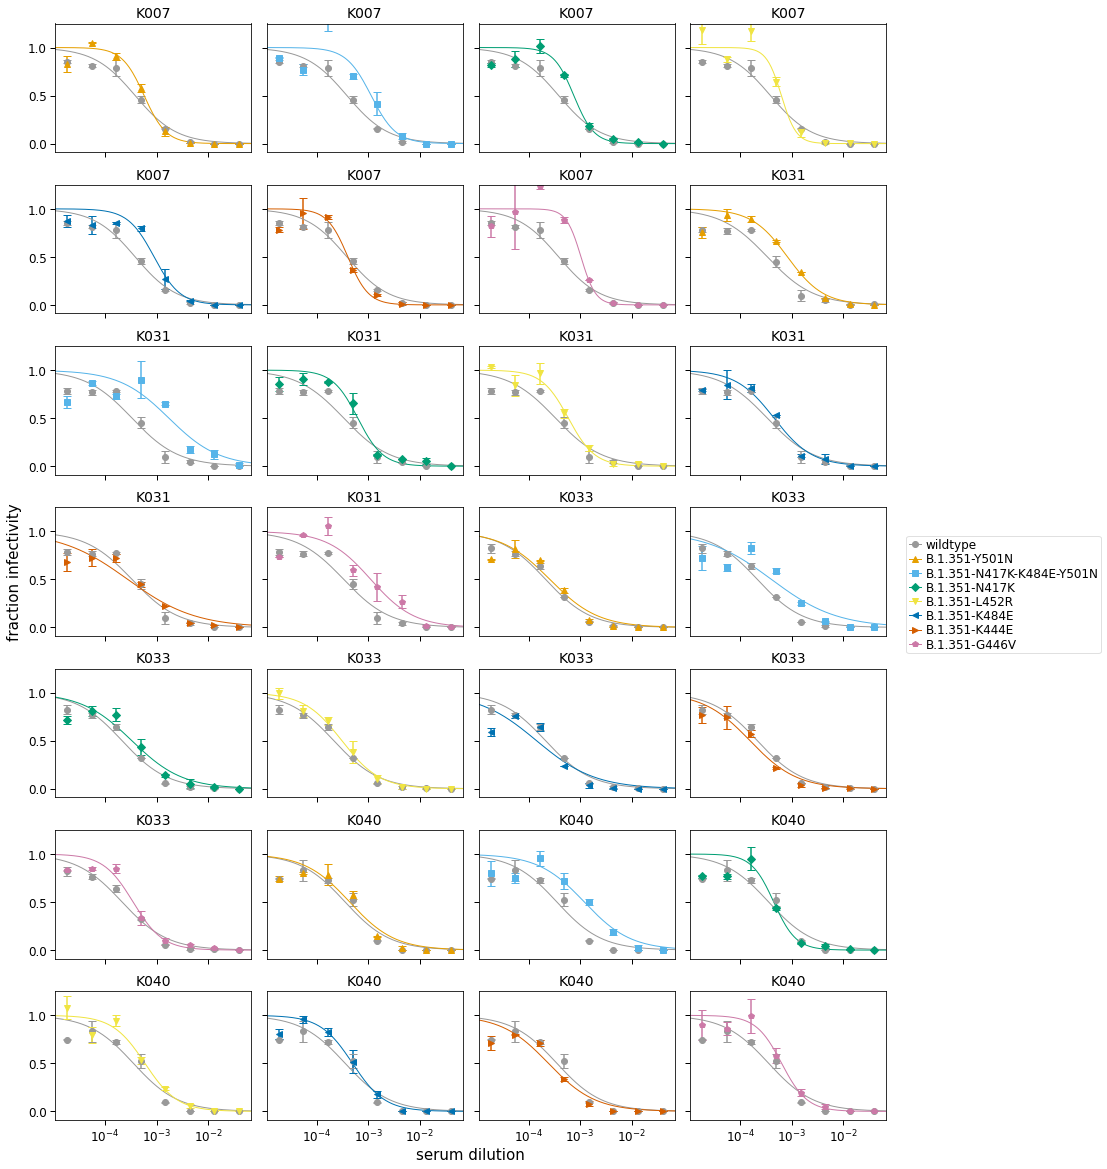

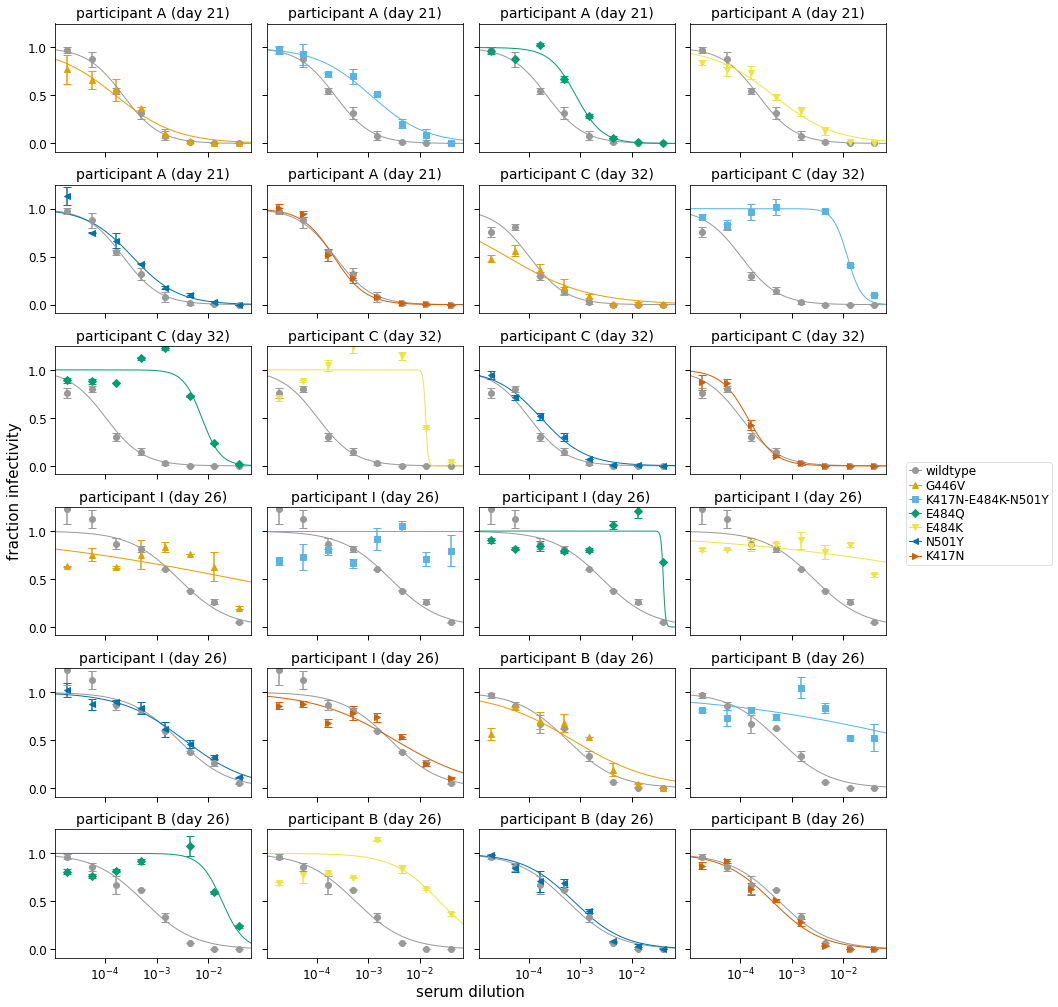

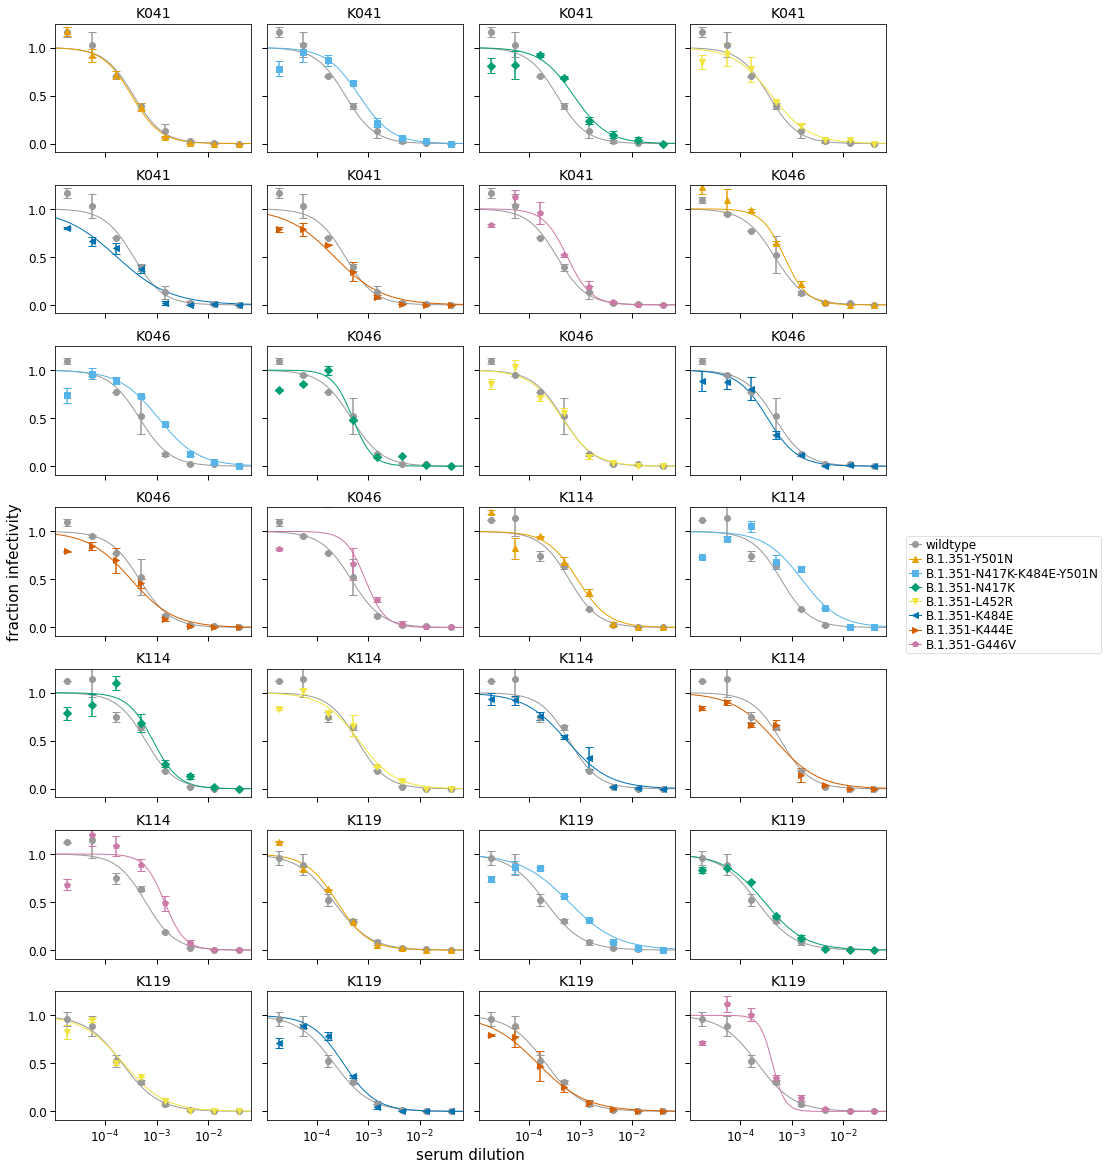

In [11]:
for d in fracinfect['date'].unique():
    fits = (neutcurve.CurveFits(fracinfect.query('date==@d'), 
                                replicate_col='replicate_on_date', 
                                fixbottom=config['fixbottom'],
                                fixtop=config['fixtop'],
                               )
           )
    xlab= 'serum dilution'
    name= 'sera'

    fig, axes = fits.plotSera(xlabel=xlab,max_viruses_per_subplot=2,
                              colors=CBPALETTE*3, 
                              markers=CBMARKERS*3,
#                               attempt_shared_legend=True,
                              fix_lims={'ymax':1.25}
                             )

    plotfile = f'{results}/{d}_mutant_neuts.pdf'
    print(f"Saving to {plotfile}")
    fig.savefig(plotfile, bbox_inches='tight')

### Calculate fold-change IC50 relative to the gemetric mean of the wildtype virus against each serum on each date
* Get neutralization titers, 
* Drop "average" replicate
* Calculate the geometric mean of the wildtype virus against each serum on each date
* Calculate fold-change IC50

In [12]:
neut_titers = (
    fitparams
    .merge((fitparams
            .query('virus == "wildtype" & replicate != "average"')
            .groupby(['serum', 'date'])
            
            # get the geometric mean of the two wildtype replicates 
            .agg(wildtype_ic50=pd.NamedAgg(column="ic50", aggfunc=geometric_mean))
            .reset_index()
           ),
           on=['serum', 'date'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['ic50'] / x['wildtype_ic50'],)
    )


display(HTML(neut_titers.head().to_html(index=False)))
neut_titers.to_csv(neut_titers_file, index=False)

serum,virus,ic50,NT50,ic50_bound,date,replicate,top,ic50_is_bound,wildtype_ic50,fold_change
K041,B.1.351-K484Q,0.001137,879.582341,interpolated,2021-08-27,1,True,False,0.000514,2.213101
K041,B.1.351-K484Q,0.001380,724.861603,interpolated,2021-08-27,2,True,False,0.000514,2.685484
K041,B.1.351-K484Q,0.001393,717.838222,interpolated,2021-08-27,average,True,False,0.000514,2.711759
K041,wildtype,0.000481,2077.386549,interpolated,2021-08-27,1,True,False,0.000514,0.937045
K041,wildtype,0.000548,1824.055316,interpolated,2021-08-27,2,True,False,0.000514,1.067185


As we can see below, the fold-change in IC50 for each wildtype replicate is no longer exactly 1 (because we are comparing to the geometric mean of the replicate measurements). Here I am pulling out hte most extreme fold_change IC50s for wildtype (relative to the geometric mean), and we see that the most extreme values are 0.75 and 1.32, for M03-day-119 on 2021-07-16. 

In [13]:
display(HTML(neut_titers.query('virus=="wildtype" & replicate != "average" & (fold_change <0.8 | fold_change >1.25)').head(100).to_html(index=False)))

serum,virus,ic50,NT50,ic50_bound,date,replicate,top,ic50_is_bound,wildtype_ic50,fold_change
K031,wildtype,0.000496,2015.434699,interpolated,2021-06-10,1,True,False,0.000335,1.481277
K031,wildtype,0.000226,4422.227189,interpolated,2021-06-10,2,True,False,0.000335,0.675093
K046,wildtype,0.000346,2888.596520,interpolated,2021-08-21,1,True,False,0.000474,0.730742
K046,wildtype,0.000648,1542.465186,interpolated,2021-08-21,2,True,False,0.000474,1.368471
K119,wildtype,0.000266,3761.207286,interpolated,2021-08-21,1,True,False,0.000207,1.281555
K119,wildtype,0.000162,6177.343348,interpolated,2021-08-21,2,True,False,0.000207,0.780302


## Read in IC50s for early 2020 (HAARVI) plasmas in RBD depletion neuts

In [14]:
haarvi_depletions=pd.DataFrame()

for i in ['1', '2', 'average']:
    df = (pd.read_csv(config['haarvi_rbd_depletions'])
                     [['serum', 'depletion', 'ic50', 'ic50_bound']]
                     .query('serum in @serum_order')
                     .rename(columns={'depletion': 'virus'})
                     .replace({'pre-depletion': 'wildtype', 'post-depletion': 'RBD antibodies depleted'})
                     .assign(NT50=lambda x: 1/x['ic50'],
                             date='October 2020',
                             replicate=i,
                             top=True,
                             ic50_is_bound=lambda x: x['ic50_bound'].map({'lower': True,'interpolated': False}),
                            )
                    )

    df= (df
         .merge((df.query('virus=="wildtype"')
                             [['serum', 'ic50']]
                             .rename(columns={'ic50': 'wildtype_ic50'})
                            ),
                            how='left',
                            on=['serum'],
                            validate='many_to_one'
                           )
                    .assign(fold_change=lambda x: x['ic50'] / x['wildtype_ic50'],)
                    )
    haarvi_depletions = pd.concat([haarvi_depletions, df])



display(HTML(haarvi_depletions.head().to_html(index=False)))

serum,virus,ic50,ic50_bound,NT50,date,replicate,top,ic50_is_bound,wildtype_ic50,fold_change
participant A (day 21),wildtype,0.000145,interpolated,6881.223206,October 2020,1,True,False,0.000145,1.000000
participant A (day 21),RBD antibodies depleted,0.001183,interpolated,845.146367,October 2020,1,True,False,0.000145,8.142049
participant B (day 26),wildtype,0.000640,interpolated,1563.438063,October 2020,1,True,False,0.000640,1.000000
participant B (day 26),RBD antibodies depleted,0.007346,interpolated,136.136752,October 2020,1,True,False,0.000640,11.484320
participant C (day 32),wildtype,0.000287,interpolated,3479.701163,October 2020,1,True,False,0.000287,1.000000


In [15]:
neut_titers = pd.concat([neut_titers, haarvi_depletions]).assign(infecting_virus=lambda x: x['serum'].map(config['infecting_virus']))
display(HTML(neut_titers.tail().to_html(index=False)))

serum,virus,ic50,NT50,ic50_bound,date,replicate,top,ic50_is_bound,wildtype_ic50,fold_change,infecting_virus
participant B (day 26),RBD antibodies depleted,0.007346,136.136752,interpolated,October 2020,average,True,False,0.000640,11.484320,early 2020
participant C (day 32),wildtype,0.000287,3479.701163,interpolated,October 2020,average,True,False,0.000287,1.000000,early 2020
participant C (day 32),RBD antibodies depleted,0.036028,27.756167,interpolated,October 2020,average,True,False,0.000287,125.366774,early 2020
participant I (day 26),wildtype,0.007130,140.247734,interpolated,October 2020,average,True,False,0.007130,1.000000,early 2020
participant I (day 26),RBD antibodies depleted,0.046926,21.310096,interpolated,October 2020,average,True,False,0.007130,6.581281,early 2020


### Plot the fold-change IC50 relative to wildtype.
We will also plot each wild type replicate (as each deviates slightly from 1).  

Saving to results/neut_titers/fold_change_IC50_average.pdf
Saving to results/neut_titers/fold_change_IC50_not_average.pdf


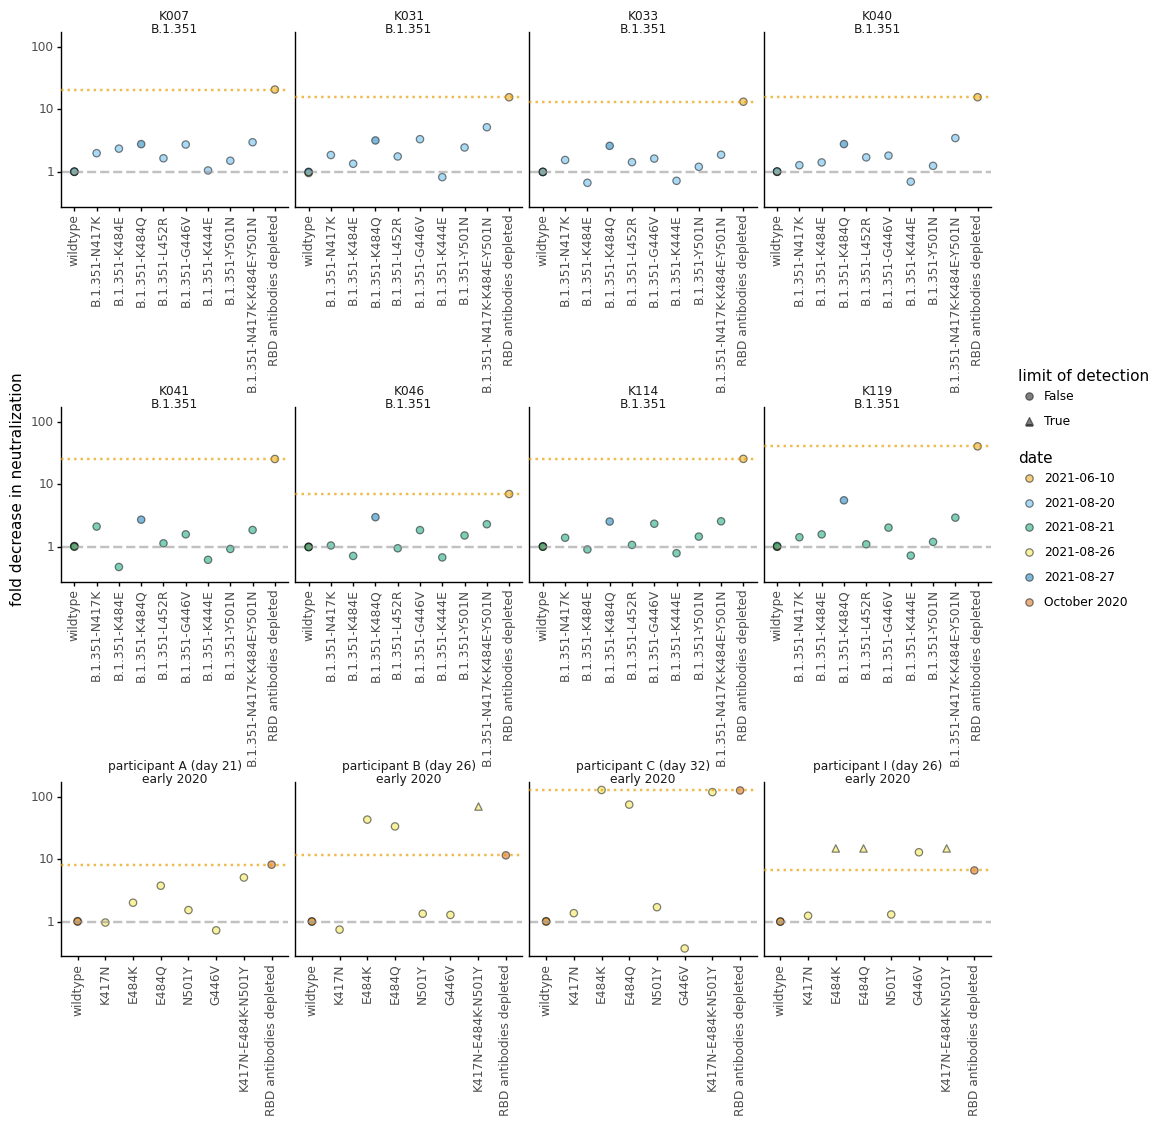

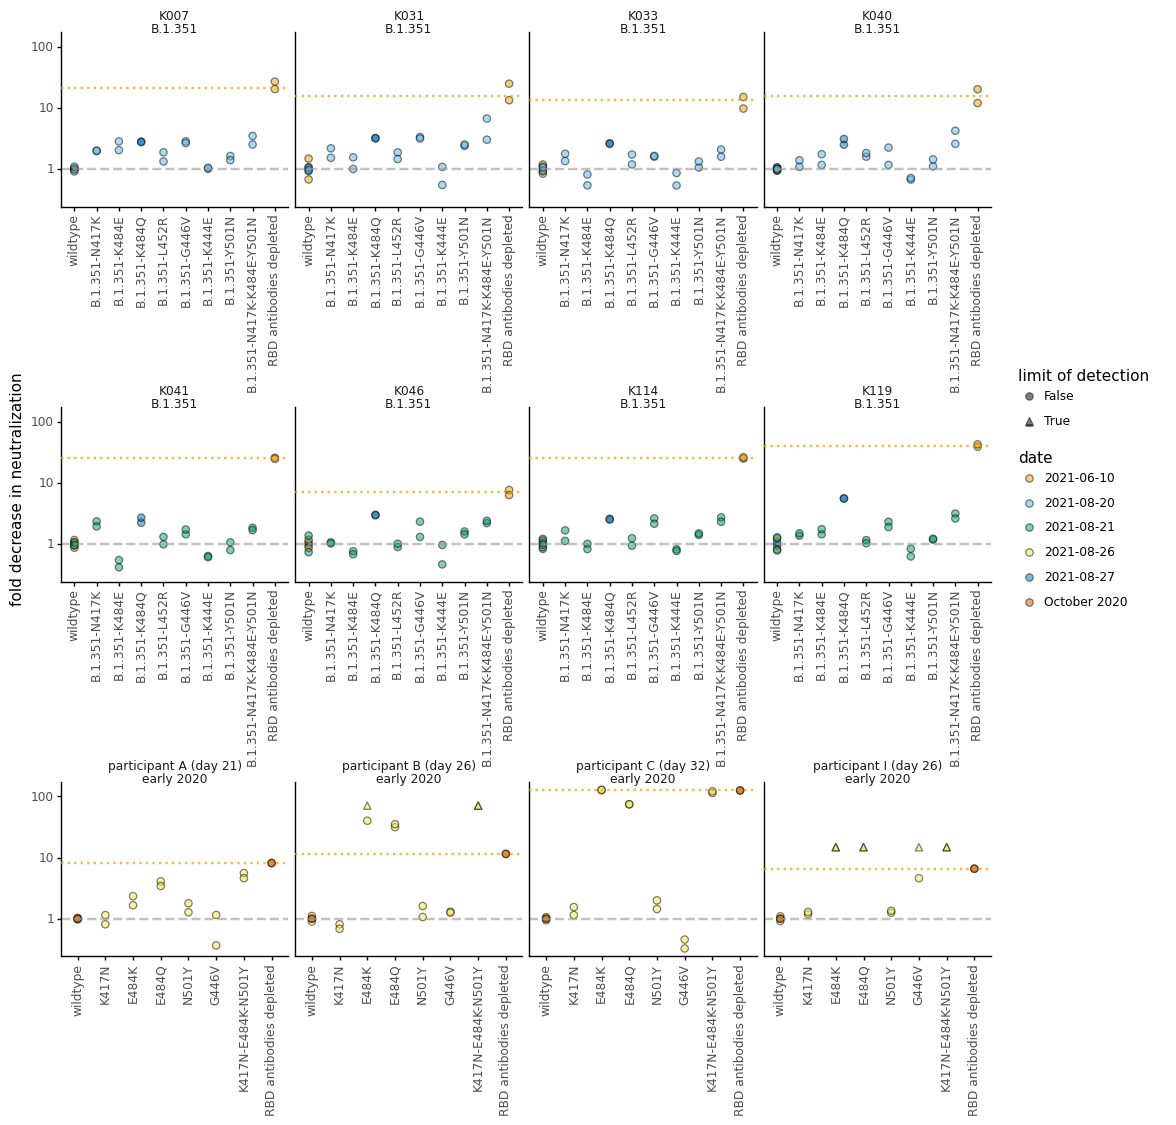

In [16]:
sera_for_further_analysis = config['sera_for_further_analysis']

neut_titers = (neut_titers
               .query('serum in @sera_for_further_analysis')
                   .assign(serum=lambda x: pd.Categorical(x['serum'],ordered=True,categories=sera_for_further_analysis),
                           virus=lambda x: pd.Categorical(x['virus'],ordered=True,categories=virus_order),
                          )
                  )

for b in ('average', 'not_average'):
    if b=='average':
        df = neut_titers.query('replicate=="average"')
    else:
        df = neut_titers.query('replicate!="average"')
    p = (ggplot(df
                ) +
         aes('virus', 'fold_change', shape='ic50_is_bound',
            ) +
         geom_point(aes(fill='date'), size=2.5, alpha=0.5) + 
         scale_y_log10(name='fold decrease in neutralization') +
         facet_wrap('~serum+infecting_virus', ncol=4, scales='free_x') +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               axis_title_x=element_blank(),
               strip_background_x=element_blank(),
               subplots_adjust={'hspace': 1.15},
               figure_size=(12, 12),
               ) +
         geom_hline(yintercept=1, linetype='dashed', size=1,
                    alpha=0.6, color=CBPALETTE[0]) +
         geom_hline(data=neut_titers.query('virus=="RBD antibodies depleted"').query('replicate=="average"'),
                    mapping=aes(yintercept='fold_change'),
                    color=CBPALETTE[1],
                    alpha=0.7,
                    size=1,
                    linetype='dotted',
                   ) +
         scale_shape_manual(values=['o','^'], name='limit of detection')+
         scale_fill_manual(values=CBPALETTE[1:])
         )

    _ = p.draw()

    plotfile = f'{results}/fold_change_IC50_{b}.pdf'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

Making plot for fold_change for all:


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 192 rows containing missing values.


Saving to results/neut_titers/fold_change_all.pdf


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 192 rows containing missing values.


Making plot for ic50 for all:


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 192 rows containing missing values.


Saving to results/neut_titers/ic50_all.pdf


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 192 rows containing missing values.


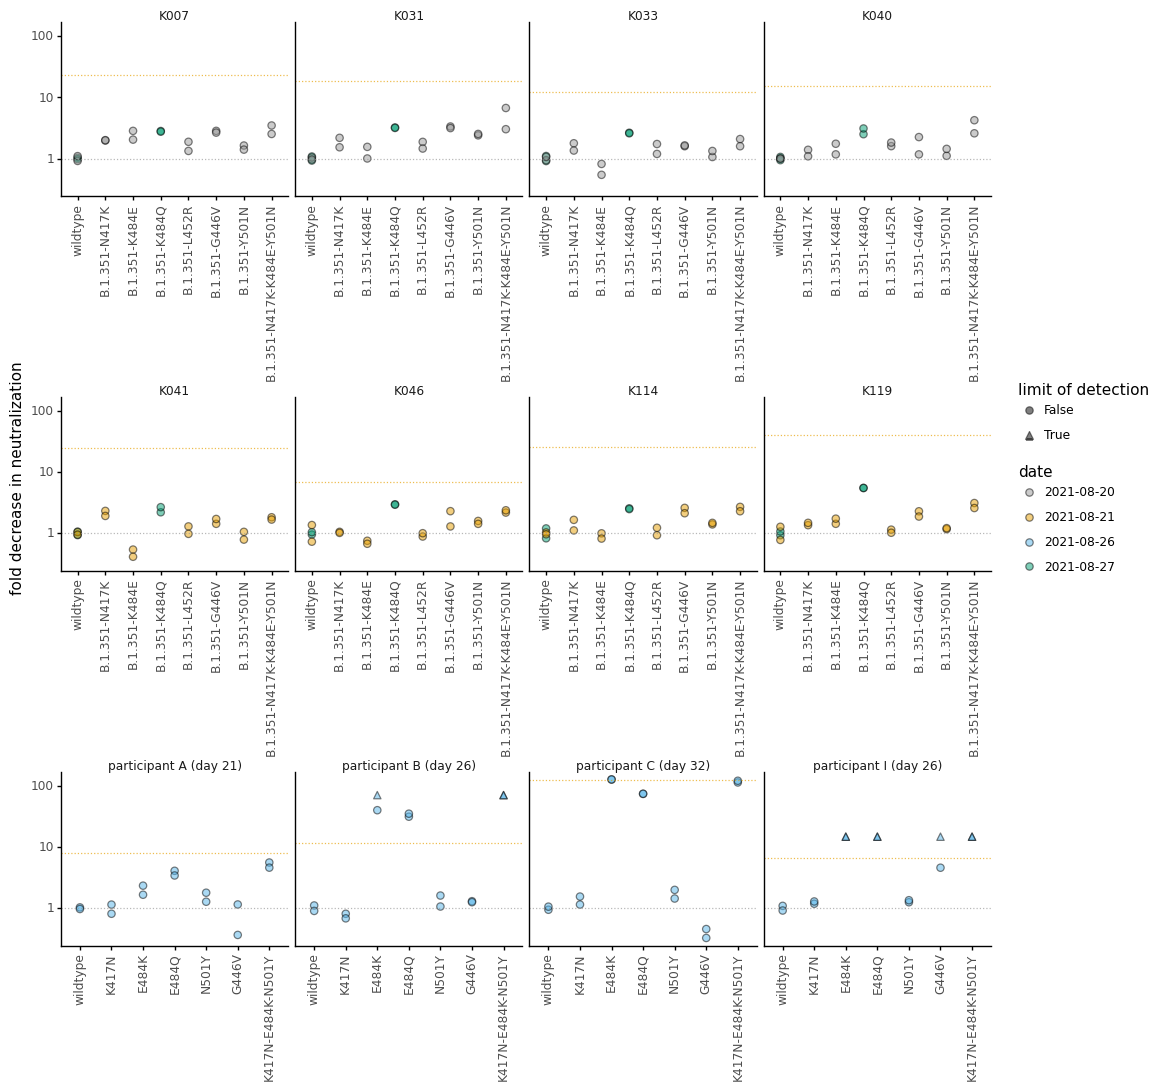

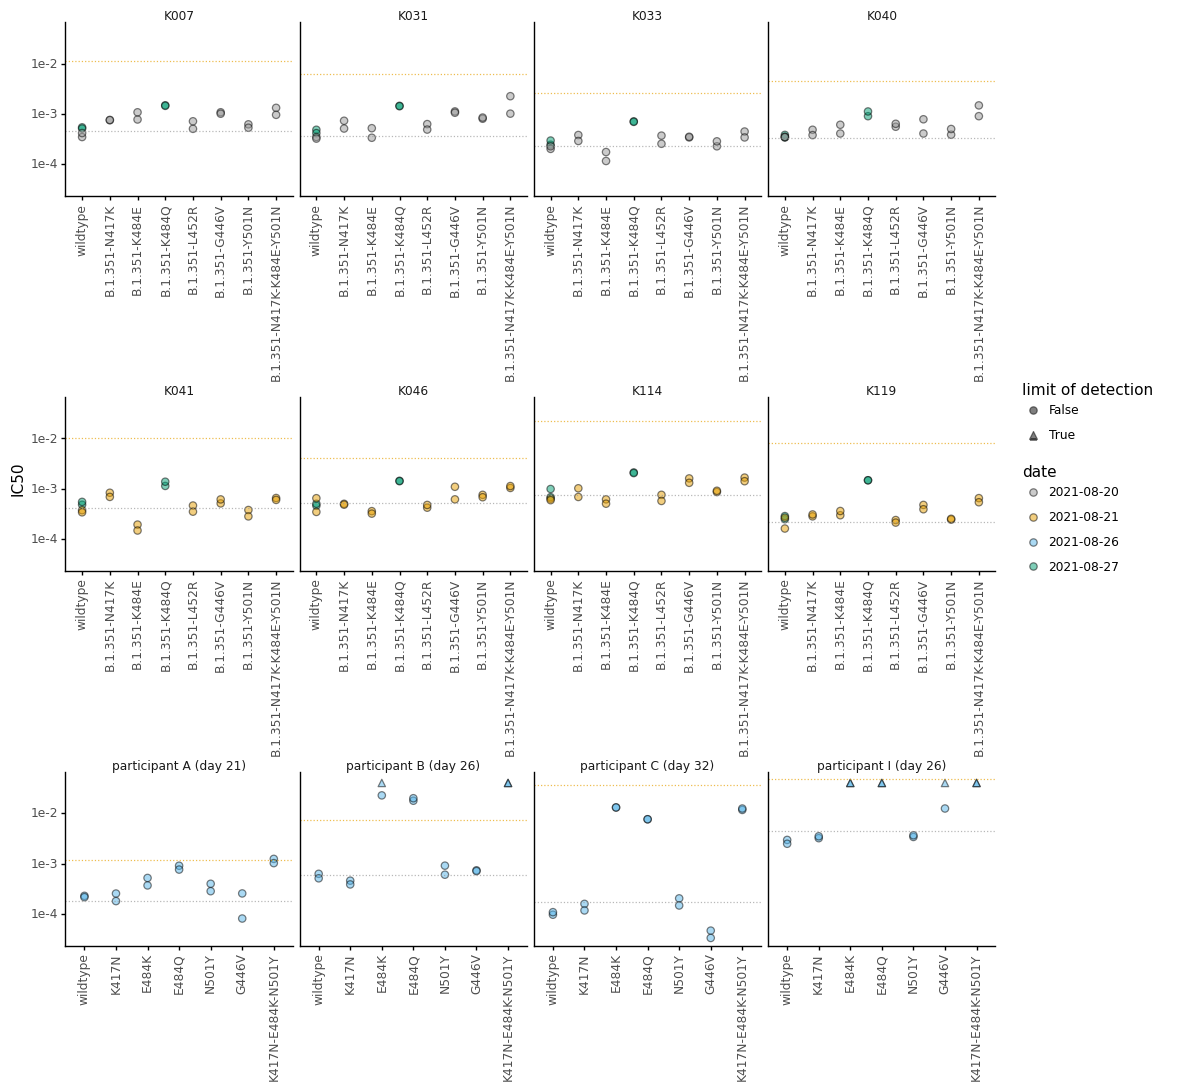

In [17]:
for metric in ['fold_change', 'ic50']:
    for virus_set, virus_subsample in config['virus_subsets'].items():
        print(f'Making plot for {metric} for {virus_set}:')
        
        ylab={'fold_change':'fold decrease in neutralization', 'ic50':'IC50'}

        dates=neut_titers.query("virus in @virus_subsample & virus not in ['wildtype', 'RBD antibodies depleted']")['date'].unique()

        p = (ggplot(neut_titers
                    .query("virus in @virus_subsample & date in @dates & replicate!= 'average'")
                    ) +
             aes('virus', metric, shape='ic50_is_bound',
                ) +
             geom_point(aes(fill='date'), size=2.5, alpha=0.5, ) + #fill='#999999', 
             scale_y_log10(name=ylab[metric]) +
             facet_wrap('~serum', ncol=4, scales='free_x') +
             theme_classic() +
             theme(axis_text_x=element_text(angle=90),
               axis_title_x=element_blank(),
               strip_background_x=element_blank(),
               subplots_adjust={'hspace': 1.15},
               figure_size=(12, 12),
               ) +
             geom_hline(data=(neut_titers
                              .query('virus in ["wildtype", "RBD antibodies depleted"] & replicate!="average"')
                              .groupby(['serum', 'virus'])
                              .agg({metric: geometric_mean})
                              .reset_index()
                             ),
                        inherit_aes=False,
                        mapping=aes(yintercept=metric, color='virus'),
                        alpha=0.7,
                        size=0.5,
                        linetype='dotted',
                       ) +
             scale_shape_manual(values=['o','^'], name='limit of detection') +
             scale_color_manual(values=CBPALETTE*3, guide=False) +
             scale_fill_manual(values=CBPALETTE*3)
             )

        _ = p.draw()

        plotfile = f'{results}/{metric}_{virus_set}.pdf'
        print(f"Saving to {plotfile}")
        p.save(plotfile, limitsize=False, verbose=False)

### Plot the results for all individuals on one plot and add the geometric mean of all 8 measurements (2 replicates * 4 sera) for each virus

Making plot for fold_change for all:


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 34 rows containing missing values.


Saving to results/neut_titers/fold_change_all_aggregate.pdf


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 34 rows containing missing values.


Making plot for ic50 for all:


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 34 rows containing missing values.


Saving to results/neut_titers/ic50_all_aggregate.pdf


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 34 rows containing missing values.


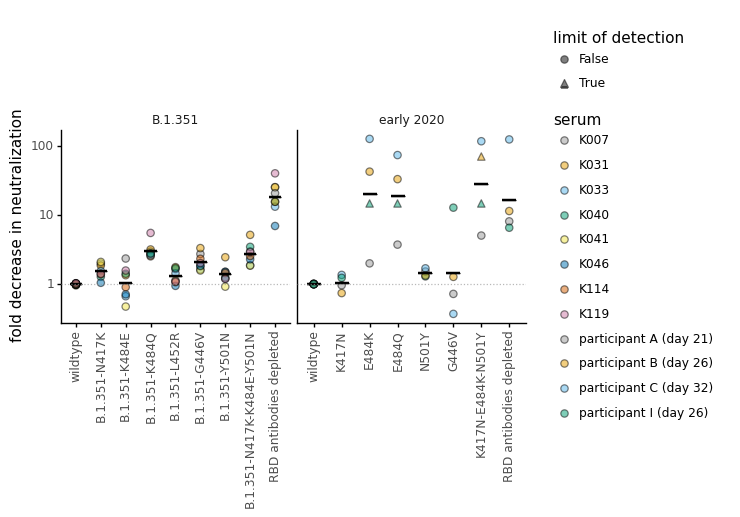

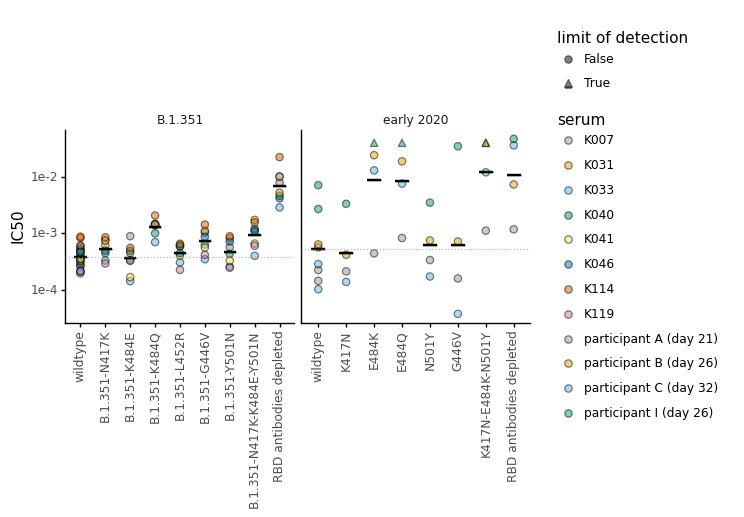

In [18]:
for metric in ['fold_change', 'ic50']:
    for virus_set, virus_subsample in config['virus_subsets'].items():
        print(f'Making plot for {metric} for {virus_set}:')
        
        ylab={'fold_change':'fold decrease in neutralization', 'ic50':'IC50'}

        dates=neut_titers.query("virus in @virus_subsample & virus not in ['wildtype']")['date'].unique()

        p = (ggplot(neut_titers
                    .query("virus in @virus_subsample & date in @dates & replicate== 'average'")
                    ) +
             aes('virus', metric, shape='ic50_is_bound', fill='serum',
                ) +
             geom_point(size=2.5, alpha=0.5, ) + 
             geom_crossbar(data=(neut_titers
                                 .query("virus in @virus_subsample & date in @dates & replicate== 'average'")
                                 .groupby(['virus', 'infecting_virus'])
                                 .agg({metric: geometric_mean})
                                 .reset_index()
                                 .dropna()
                                ),
                           inherit_aes=False,
                           mapping=aes(x='virus', y=metric, ymin=metric, ymax=metric),
                  ) +
             scale_y_log10(name=ylab[metric]) +
             theme_classic() +
             theme(axis_text_x=element_text(angle=90),
                   axis_title_x=element_blank(),
                   strip_margin_y=0.35,
                   strip_background_x=element_blank(),
                   figure_size=(6, 2.5),
                   ) +
             geom_hline(data=(neut_titers
                              .query('virus in ["wildtype"] & replicate=="average"')
                              .groupby(['virus', 'infecting_virus'])
                              .agg({metric: geometric_mean})
                              .reset_index()
                             ),
                        inherit_aes=False,
                        mapping=aes(yintercept=metric, color='virus'),
                        alpha=0.7,
                        size=0.5,
                        linetype='dotted',
                       ) +
             scale_shape_manual(values=['o','^'], name='limit of detection') +
             scale_color_manual(values=CBPALETTE*3, guide=False) +
             scale_fill_manual(values=CBPALETTE*3) +
             facet_wrap('~infecting_virus', scales='free_x')
             )

        _ = p.draw()

        plotfile = f'{results}/{metric}_{virus_set}_aggregate.pdf'
        print(f"Saving to {plotfile}")
        p.save(plotfile, limitsize=False, verbose=False)

Making plot for fold_change for all:


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 34 rows containing missing values.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


Saving to results/neut_titers/fold_change_all_aggregate_nocolors.pdf


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 34 rows containing missing values.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


Making plot for ic50 for all:


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 34 rows containing missing values.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


Saving to results/neut_titers/ic50_all_aggregate_nocolors.pdf


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_hline : Removed 34 rows containing missing values.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


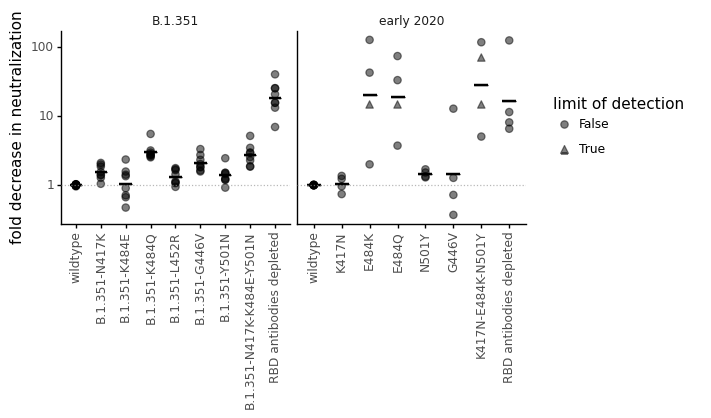

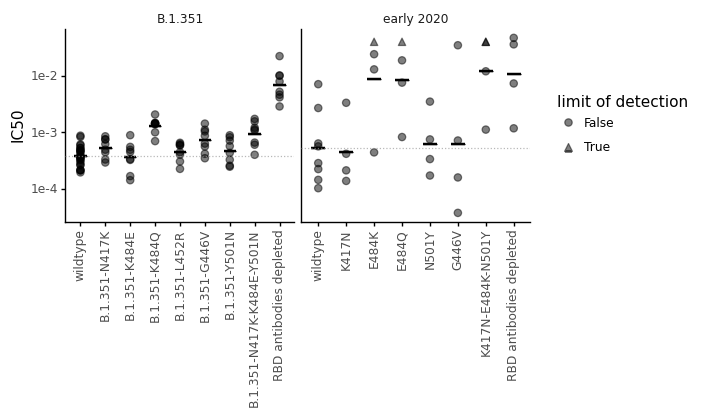

In [19]:
for metric in ['fold_change', 'ic50']:
    for virus_set, virus_subsample in config['virus_subsets'].items():
        print(f'Making plot for {metric} for {virus_set}:')
        
        ylab={'fold_change':'fold decrease in neutralization', 'ic50':'IC50'}

        dates=neut_titers.query("virus in @virus_subsample & virus not in ['wildtype']")['date'].unique()

        p = (ggplot(neut_titers
                    .query("virus in @virus_subsample & date in @dates & replicate== 'average'")
                    ) +
             aes('virus', metric, shape='ic50_is_bound',
                ) +
             geom_point(size=2.5, alpha=0.5, ) + 
             geom_crossbar(data=(neut_titers
                                 .query("virus in @virus_subsample & date in @dates & replicate== 'average'")
                                 .groupby(['virus', 'infecting_virus'])
                                 .agg({metric: geometric_mean})
                                 .reset_index()
                                 .dropna()
                                ),
                           inherit_aes=False,
                           mapping=aes(x='virus', y=metric, ymin=metric, ymax=metric),
                  ) +
             scale_y_log10(name=ylab[metric]) +
             theme_classic() +
             theme(axis_text_x=element_text(angle=90),
                   axis_title_x=element_blank(),
                   strip_margin_y=0.35,
                   strip_background_x=element_blank(),
                   figure_size=(6, 2.5),
                   ) +
             geom_hline(data=(neut_titers
                              .query('virus in ["wildtype"] & replicate=="average"')
                              .groupby(['virus', 'infecting_virus'])
                              .agg({metric: geometric_mean})
                              .reset_index()
                             ),
                        inherit_aes=False,
                        mapping=aes(yintercept=metric, color='virus'),
                        alpha=0.7,
                        size=0.5,
                        linetype='dotted',
                       ) +
             scale_shape_manual(values=['o','^'], name='limit of detection') +
             scale_color_manual(values=CBPALETTE*3, guide=False) +
             scale_fill_manual(values=CBPALETTE*3) +
             facet_wrap('~infecting_virus', scales='free_x')
             )

        _ = p.draw()

        plotfile = f'{results}/{metric}_{virus_set}_aggregate_nocolors.pdf'
        print(f"Saving to {plotfile}")
        p.save(plotfile, limitsize=False, verbose=False)

## Rename viruses such that they are comparable between the B.1.351 and early 2020 samples. 
Essentially, I want the virus names to be like this:
* wildtype: wildtype
* B.1.351: wildtype
* mock: wildtype
* B.1.351-N417K: 417K/N
* B.1.351-K484E: 484K/E
* B.1.351-K484Q: 484Q
* B.1.351-L452R: L452R
* B.1.351-G446V: G446V
* B.1.351-K444E: K444E
* B.1.351-Y501N: 501Y/N
* B.1.351-N417K-K484E-Y501N: 417-484-501
* K417N: 417K/N
* E484K: 484K/E
* E484Q: 484Q
* N501Y: 501Y/N
* G446V: G446V
* K417N-E484K-N501Y: 417-484-501
* RBD antibodies depleted: RBD antibodies depleted

In [20]:
neut_titers.query('virus=="wildtype" & infecting_virus=="B.1.351"')['ic50'].agg(geometric_mean)

0.0003848677285585624

,serum,virus,ic50,NT50,ic50_bound,date,replicate,top,ic50_is_bound,wildtype_ic50,fold_change,infecting_virus,virus_simplified_names,virus_labels
0,K041,B.1.351-K484Q,0.001137,879.582341,interpolated,2021-08-27,1,True,False,0.000514,2.213101,B.1.351,484Q,484Q
1,K041,B.1.351-K484Q,0.001380,724.861603,interpolated,2021-08-27,2,True,False,0.000514,2.685484,B.1.351,484Q,484Q
2,K041,B.1.351-K484Q,0.001393,717.838222,interpolated,2021-08-27,average,True,False,0.000514,2.711759,B.1.351,484Q,484Q
3,K041,wildtype,0.000481,2077.386549,interpolated,2021-08-27,1,True,False,0.000514,0.937045,B.1.351,wildtype,wildtype
4,K041,wildtype,0.000548,1824.055316,interpolated,2021-08-27,2,True,False,0.000514,1.067185,B.1.351,wildtype,wildtype


[False True]
Making plot for fold_change for all:
Saving to results/neut_titers/fold_change_all_aggregate_nofacet.pdf
Making plot for ic50 for all:
Saving to results/neut_titers/ic50_all_aggregate_nofacet.pdf


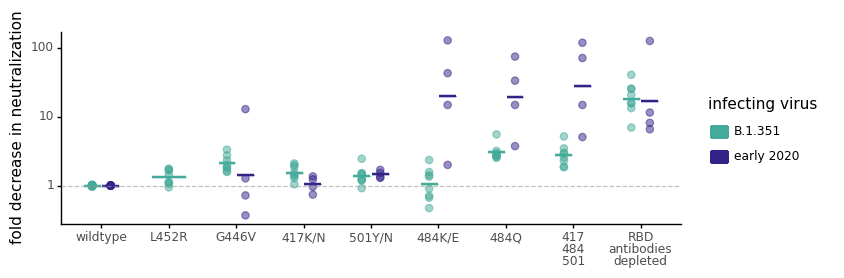

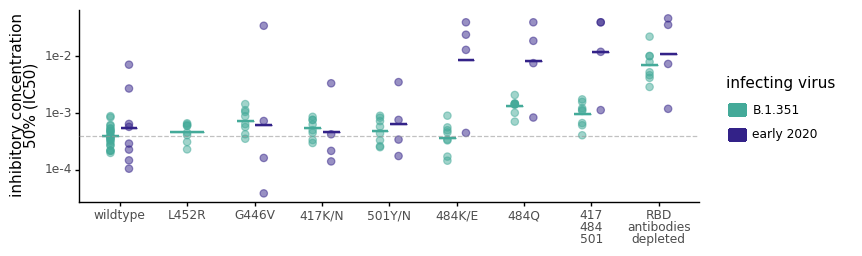

In [21]:
neut_titers=(neut_titers.assign(virus_simplified_names=lambda x: x['virus']
                                .map(config['virus_simplified_names']),
                                virus_labels=lambda x: x['virus_simplified_names']
                                .replace({'RBD antibodies depleted':'RBD\nantibodies\ndepleted',
                                          '417-484-501':'417\n484\n501'
                                         }
                                        ),
                               )
            )

display(HTML(neut_titers.head().to_html()))

print(neut_titers['ic50_is_bound'].unique())

for metric in ['fold_change', 'ic50']:
    for virus_set, virus_subsample in config['virus_subsets'].items():
        print(f'Making plot for {metric} for {virus_set}:')
        
        ylab={'fold_change':'fold decrease in neutralization', 
              'ic50':'inhibitory concentration\n50% (IC50)'
             }
        yintercept={'fold_change':1, 
                    'ic50':(neut_titers
                            .query('virus=="wildtype" & infecting_virus=="B.1.351"')
                            ['ic50']
                            .agg(geometric_mean)
                           )
                   }

        p = (ggplot(neut_titers
                    .query("virus in @virus_subsample & replicate=='average'")
                    .assign(virus_labels=lambda x: pd.Categorical(x['virus_labels'],
                                                                  ordered=True,
                                                                  categories=(config['virus_simplified_names_order']+
                                                                              ['417\n484\n501',
                                                                               'RBD\nantibodies\ndepleted'])),
                           )
                    ) +
             aes('virus_labels', 
                 metric, 
                 fill='infecting_virus', 
                 color='infecting_virus',
                ) +
             geom_point(position=position_dodge(width=0.55), size=2.5, alpha=0.5) +
             geom_crossbar(data=(neut_titers
                                 .query("virus in @virus_subsample & replicate=='average'")
                                 .groupby(['virus_labels', 'infecting_virus'])
                                 .agg({metric: geometric_mean})
                                 .reset_index()
                                 .dropna()
                                ),
#                            inherit_aes=False,
                           mapping=aes(x='virus_labels', y=metric, ymin=metric, ymax=metric),
                           position=position_dodge(width=0.55),
                  ) +
             geom_hline(yintercept=yintercept[metric],
                        linetype='dashed', size=0.5,
                        alpha=0.6, 
                        color=CBPALETTE[0]) +
             scale_y_log10(name=ylab[metric]) +
             theme_classic() +
             theme(axis_title_x=element_blank(),
                   figure_size=(8, 2.5),
                   ) +
             scale_fill_manual(values=['#44AA99', '#332288'], name='infecting virus\n')+
             scale_color_manual(values=['#44AA99', '#332288'], name='infecting virus\n')
             )

        _ = p.draw()

        plotfile = f'{results}/{metric}_{virus_set}_aggregate_nofacet.pdf'
        print(f"Saving to {plotfile}")
        p.save(plotfile, limitsize=False, verbose=False)